In [1]:
## Importables
from platform import python_version
print(f"Python version {python_version()}")

import sys
import os

sys.path.append("/windir/c/Users/redas/Desktop/jupyter_directory/helpers/src/helpers/")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import numpy as np
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize
from math import log10, log2, ceil, floor, sqrt
from missingpy import MissForest

# And grab the helpers
import sys
sys.path.append("/windir/c/Users/redas/Desktop/jupyter_directory/helpers/src/helpers/")
from helpers import general_helpers as gh
from helpers import stats_helpers as sh
from helpers import mpl_plotting_helpers as mph
from helpers.proteomics_helpers import Peptide

Python version 3.10.12
Loading the module: helpers.general_helpers

Loading the module: helpers.stats_helpers.py

numpy        1.22.4
scipy         1.8.1
pandas        1.4.2

Loading the module: helpers.mpl_plotting_helpers

Loading the module: helpers.argcheck_helpers

Loading the module: helpers.pandas_helpers

pandas        1.4.2
numpy         1.22.4

matplotlib    3.5.2
numpy         1.22.4



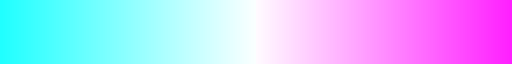

In [2]:
mph.trans

In [3]:
## Variables
filename = "PTPN22_TCPTP_SHP1_U0126_pTyr_DDA_2.xls"

rename_cols = {"UNIPROT Gene Name" : "Gene name",                                
               "phosphosite annotated" : "Site",                            
                "peakarea manual 1 rep1 thresholded timepoint1" : "JE6 0m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint1" : "JE6 0m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint1" : "JE6 0m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint1" : "JE6 0m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint1" : "JE6 0m DMSO R5",
                "peakarea manual 1 rep1 thresholded timepoint2" : "JE6 5m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint2" : "JE6 5m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint2" : "JE6 5m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint2" : "JE6 5m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint2" : "JE6 5m DMSO R5", 
                "peakarea manual 1 rep1 thresholded timepoint3" : "JE6 0m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint3" : "JE6 0m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint3" : "JE6 0m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint3" : "JE6 0m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint3" : "JE6 0m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint4" : "JE6 5m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint4" : "JE6 5m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint4" : "JE6 5m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint4" : "JE6 5m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint4" : "JE6 5m U0126 R5", 
               "peakarea manual 1 rep1 thresholded timepoint9" : "J.TCPTP- 0m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint9" : "J.TCPTP- 0m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint9" : "J.TCPTP- 0m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint9" : "J.TCPTP- 0m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint9" : "J.TCPTP- 0m DMSO R5",
                "peakarea manual 1 rep1 thresholded timepoint10" : "J.TCPTP- 5m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint10" : "J.TCPTP- 5m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint10" : "J.TCPTP- 5m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint10" : "J.TCPTP- 5m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint10" : "J.TCPTP- 5m DMSO R5", 
                "peakarea manual 1 rep1 thresholded timepoint11" : "J.TCPTP- 0m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint11" : "J.TCPTP- 0m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint11" : "J.TCPTP- 0m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint11" : "J.TCPTP- 0m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint11" : "J.TCPTP- 0m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint12" : "J.TCPTP- 5m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint12" : "J.TCPTP- 5m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint12" : "J.TCPTP- 5m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint12" : "J.TCPTP- 5m U0126 R4",
#                "peakarea manual 1 rep5 thresholded timepoint12" : "J.TCPTP- 5m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint5" : "J.PTPN22- 0m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint5" : "J.PTPN22- 0m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint5" : "J.PTPN22- 0m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint5" : "J.PTPN22- 0m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint5" : "J.PTPN22- 0m DMSO R5",
                "peakarea manual 1 rep1 thresholded timepoint6" : "J.PTPN22- 5m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint6" : "J.PTPN22- 5m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint6" : "J.PTPN22- 5m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint6" : "J.PTPN22- 5m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint6" : "J.PTPN22- 5m DMSO R5", 
                "peakarea manual 1 rep1 thresholded timepoint7" : "J.PTPN22- 0m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint7" : "J.PTPN22- 0m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint7" : "J.PTPN22- 0m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint7" : "J.PTPN22- 0m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint7" : "J.PTPN22- 0m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint8" : "J.PTPN22- 5m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint8" : "J.PTPN22- 5m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint8" : "J.PTPN22- 5m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint8" : "J.PTPN22- 5m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint8" : "J.PTPN22- 5m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint13" : "J.SHP1- 0m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint13" : "J.SHP1- 0m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint13" : "J.SHP1- 0m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint13" : "J.SHP1- 0m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint13" : "J.SHP1- 0m DMSO R5",
                "peakarea manual 1 rep1 thresholded timepoint14" : "J.SHP1- 5m DMSO R1",   
                "peakarea manual 1 rep2 thresholded timepoint14" : "J.SHP1- 5m DMSO R2",   
                "peakarea manual 1 rep3 thresholded timepoint14" : "J.SHP1- 5m DMSO R3",   
                "peakarea manual 1 rep4 thresholded timepoint14" : "J.SHP1- 5m DMSO R4",
                "peakarea manual 1 rep5 thresholded timepoint14" : "J.SHP1- 5m DMSO R5", 
                "peakarea manual 1 rep1 thresholded timepoint15" : "J.SHP1- 0m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint15" : "J.SHP1- 0m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint15" : "J.SHP1- 0m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint15" : "J.SHP1- 0m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint15" : "J.SHP1- 0m U0126 R5",
                "peakarea manual 1 rep1 thresholded timepoint16" : "J.SHP1- 5m U0126 R1",   
                "peakarea manual 1 rep2 thresholded timepoint16" : "J.SHP1- 5m U0126 R2",   
                "peakarea manual 1 rep3 thresholded timepoint16" : "J.SHP1- 5m U0126 R3",   
                "peakarea manual 1 rep4 thresholded timepoint16" : "J.SHP1- 5m U0126 R4",
                "peakarea manual 1 rep5 thresholded timepoint16" : "J.SHP1- 5m U0126 R5",        
                "assigned sequence" : "Modified Sequence", 
                "Kegg unique index" : "KEGG category",
                "peptide sequence GCT format centered on 1st site" : "Flanking Sequence (1)",
                "peptide sequence GCT format centered on 2nd site" : "Flanking Sequence (2)",
                "peptide sequence GCT format centered on 3rd site" : "Flanking Sequence (3)"
              }

colours = [mph.colours["monos"][3:7],
           mph.colours["pinks"][2:6],
           mph.colours["blues"][-4:],
           mph.colours["purples"][-4:]]


group_inds = {"JE6 0m DMSO" : [2,3,4,5,6],
              "JE6 5m DMSO" : [7,8,9,10,11],
              "JE6 0m U0126" : [12,13,14,15,16],
              "JE6 5m U0126" : [17,18,19,20,21],
              "TCP 0m DMSO"  : [22,23,24,25,26],
              "TCP 5m DMSO"  : [27,28,29,30,31],
              "TCP 0m U0126" : [32,33,34,35,36],
              "TCP 5m U0126" : [37,38,39,40],
              "N22 0m DMSO"  : [41,42,43,44,45],
              "N22 5m DMSO"  : [46,47,48,49,50],
              "N22 0m U0126" : [51,52,53,54,55],
              "N22 5m U0126" : [56,57,58,59,60],
              "SHP 0m DMSO"  : [61,62,63,64,65],
              "SHP 5m DMSO"  : [66,67,68,69,70],
              "SHP 0m U0126" : [71,72,73,74,75],
              "SHP 5m U0126" : [76,77,78,79,80]
             }

comparisons = [("TCP 0m DMSO", "JE6 0m DMSO"),
               ("N22 0m DMSO", "JE6 0m DMSO"),
               ("SHP 0m DMSO", "JE6 0m DMSO"), # Basal state/JE6 comps DMSO
               ("TCP 5m DMSO", "JE6 5m DMSO"),
               ("N22 5m DMSO", "JE6 5m DMSO"),
               ("SHP 5m DMSO", "JE6 5m DMSO"), # Stim state/JE6 comps DMSO
               ("JE6 5m DMSO", "JE6 0m DMSO"),
               ("TCP 5m DMSO", "TCP 0m DMSO"),
               ("N22 5m DMSO", "N22 0m DMSO"),
               ("SHP 5m DMSO", "SHP 0m DMSO"), # 5m Stims DMSO
               ("TCP 0m U0126", "JE6 0m U0126"),
               ("N22 0m U0126", "JE6 0m U0126"),
               ("SHP 0m U0126", "JE6 0m U0126"), # Basal state/JE6 comps DMSO
               ("TCP 5m U0126", "JE6 5m U0126"),
               ("N22 5m U0126", "JE6 5m U0126"),
               ("SHP 5m U0126", "JE6 5m U0126"), # Stim state/JE6 comps DMSO
               ("JE6 0m U0126", "JE6 0m DMSO"),
               ("TCP 0m U0126", "TCP 0m DMSO"),
               ("N22 0m U0126", "N22 0m DMSO"),
               ("SHP 0m U0126", "SHP 0m DMSO"), # Basal state +/- U0126
               ("JE6 5m U0126", "JE6 5m DMSO"),
               ("TCP 5m U0126", "TCP 5m DMSO"),
               ("N22 5m U0126", "N22 5m DMSO"),
               ("SHP 5m U0126", "SHP 5m DMSO"), # Stim state +/- U0126
               ("JE6 5m U0126", "JE6 0m DMSO"),
               ("TCP 5m U0126", "TCP 0m DMSO"),
               ("N22 5m U0126", "N22 0m DMSO"),
               ("SHP 5m U0126", "SHP 0m DMSO"), # 5m stims U0126
               ]

reps_2 = [3,8,13,18,23,28,33,38,42,47,52,57,62,67,72,77]

textdict = dict(fontfamily = "sans-serif",
                font = "Arial",
                fontsize = 8)

In [4]:
# Import the things for ssgsea
from py_scripts import generate_ssgsea_files as gsf
from py_scripts import managing_ssgsea_outputs as mso

# For GCT file writing
## Need to keep only the input values and flanks

def ptmsea_transform(a_qvalue, a_foldchange, head = "No"):
    if type(a_qvalue) == str or type(a_foldchange) == str:
        return head
    if a_qvalue != a_qvalue or a_foldchange != a_foldchange:
        return float("nan")
    if a_foldchange < 0:
        return -10 * log10(a_qvalue) *-1
    else:
        return -10 * log10(a_qvalue) * 1

def duplicate_flanks(a_row,
                     flank_locs,   # list of indices for the places with flanking sequences
                     ):
    flank_num = len(flank_locs)
    new_rows = [[] for _ in range(flank_num)] # Make the new rows
    flanks = []
    f_ind = -1
    seen = False
    for i in range(len(a_row)):               # loop over the size of the row
        if i not in flank_locs:               # If this is not a flank
            for j in range(flank_num):
                new_rows[j].append(a_row[i])  # Add this info to each sublist
        elif i in flank_locs:
            flanks.append(a_row[i])
            if not seen:
                for j in range(flank_num):
                    new_rows[j].append("FLANK ME BABY")
                seen = True
            if f_ind == -1:
                f_ind = i
    for i in range(flank_num):
        new_rows[i][f_ind] = flanks[i]
    return new_rows

def dup_flanks_matrix(a_matrix, flank_locs):
    new_matr = []
    for row in a_matrix:
        exp = duplicate_flanks(row, flank_locs)
        new_matr += exp
    return new_matr

def write_gct_file(index,    # Flanking sequences with -p 
                    values,   # values per flanking sequence, len(values[i]) == len(headers), len(values) == len(index)
                    headers, # Headers for the columns
                    outfile = "bullshit.gct" # File to write, include path and .gct
                    ):
    # GCT file has some info up top, we take it
    gct = [[fr"#1.3"], # Tells programs its a GCT 1.3 file
           [len(index), len(headers), 0, 0], # number of rows, number of cols, and metadata shit
           ["flanking_seq"] + headers] 
    for i in range(len(index)):
        gct.append([index[i]] + values[i])
    gct = [gh.list_to_str(row) for row in gct]
    gh.write_outfile(gct, outfile, writestyle = "w")
    return None

Loading the module: helpers.general_helpers

Loading the module: helpers.argcheck_helpers



In [5]:
def keep_first(a_matrix, keycol = "U_ID", heads = 0):
    keepers = []
    seen = []
    keyind = a_matrix[heads].index(keycol)
    for row in a_matrix:
        if row[keyind] not in seen:
            keepers.append(row)
            seen.append(row[keyind])
    return keepers

In [6]:
# loading files in and massaging the data


def filter_df_rows(a_df, column = "U_ID"):
    cols = list(a_df.columns)
    keycol = cols.index(column)
    a_list = list(a_df.to_numpy())
    first_occ = []
    first_key = []
    for row in a_list:
        if row[keycol] not in first_key:
            first_occ.append(row)
            first_key.append(row[keycol])
        else:
            pass
    return pd.DataFrame(first_occ, columns = cols)

def read_and_filter(a_file, columns, rename = False):
    file = pd.read_excel(a_file)
    file = file[columns]
    if rename:
        file = file.rename(rename, axis = "columns")
    file["U_ID"] = file["Gene name"].map(str) + "$^{" + file["Site"].map(str) + "}$"
    file["Median Row Intensity"] = file[[col for col in list(file.columns) if " R" in col]].median(axis=1)
    file["Total Missing Values in Row"] = file[[col for col in list(file.columns) if " R" in col]].isnull().sum(axis=1)
    f = sorted([list(row) for row in file.to_numpy()], key = lambda x: (x[-3], x[-1], -x[-2]))
    print(len(f))
    f = keep_first([list(file.columns)] + f, keycol = "U_ID", heads = 0)
    print(len(f))
    file = pd.DataFrame(f[1:], columns = f[0])
    return file

def find_lims(all_qs,all_fcs):
    qs = gh.unpack_list(all_qs)
    fc = [abs(item) for item in gh.unpack_list(all_fcs) if item == item]
    return round(-log10(min(qs)))+1, round(max(fc))+1

In [7]:
# PCA function to make my life less miserable
def square_bounds(mpl_axes, inplace = False):
    ticks = list(mpl_axes.get_xticks()) + list(mpl_axes.get_yticks())
    if inplace:
        mpl_axes.set_xlim(min(ticks), max(ticks))
        mpl_axes.set_ylim(min(ticks), max(ticks))
    else:
        return min(ticks), max(ticks)

def pca_analysis(a_df, pca_kwargs = dict(n_components = 2,
                                         whiten = False,
                                         svd_solver = "full",
                                         tol = 0)):
    std_scalar = StandardScaler()
    scaled = std_scalar.fit_transform(a_df.transpose())
    pca_analysis = PCA(**pca_kwargs)
    components = pca_analysis.fit_transform(scaled)
    components = gh.transpose(*[list(point) for point in list(components)])
    return components, pca_analysis

def nmf_analysis(a_df, nmf_kwargs = dict(n_components = 2, 
                                     init = "nndsvd", # preserves sparseness
                                     solver = "mu", # multiplicative update
                                     beta_loss = "frobenius", # stable, but slow
                                     alpha_W = 0,  # default
                                     alpha_H = 0,  # default
                                     l1_ratio = 0  # default
                                    )):
    #std_scalar = StandardScaler()
    #scaled = std_scalar.fit_transform(a_df.transpose())
    norms = normalize(a_df)
    nmf_analysis = NMF(**nmf_kwargs)
    W = nmf_analysis.fit_transform(norms)
    H = nmf_analysis.components_
    return H, W
    
def cluster_plotting(dataframes, # list with minimum 1 df
                 groups,     
                 expnames, # should match len(dataframes)
                 filenames,# should match len(dataframes)
                 group_slices, #assumes reps are clustered in list
                 labels,       # should correspons to len(group_slices)
                 colours,      # list of lists, each sublist should correspond to len(group_slices)
                 markers = ["o","^", "s"],
                 cluster = 'PCA', # other option is NNMF
                 markersize=100, 
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                 square = True,
                 pca_kwargs = dict(n_components = 30,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),
                 nmf_kwargs = dict(n_components = 2, 
                                   init = "nndsvd", # preserves sparseness
                                   solver = "mu", # multiplicative update
                                   beta_loss = "frobenius", # stable, but slow
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0  # default
                                    )):
    # Get the data columns from the dataframes, remove
    # missing values, run PCA analysis with sklearn,
    # scatter
    
    # Grab the columns corresponding to the groups of data. Assumes the 'groups' strings
    # are a substring of the column headers
    dfs = [df[[name for name in list(df.columns) if any(s in name for s in groups)]] for df in dataframes]
    # Remove any row with missing values, as PCA doesn't tolerate MVs
    dfs = [df.dropna() for df in dfs]
    axes = []
    i = 0
    print(cluster)
    for df in dfs:
        if cluster.lower() == "pca":
            print('here')
            components,pca = pca_analysis(df, pca_kwargs = pca_kwargs)
        else:
            # will add nmf soon
            print('don')
            components,nmf = nmf_analysis(df, nmf_kwargs = nmf_kwargs)
        fig, ax = plt.subplots(figsize = (6,6))
        # Next, loop over the slices and scatter
        j = 0
        print(len(components[0]))
        for g in group_slices:
            ax.scatter(components[0][g], components[1][g], 
                       color = colours[i][j],
                       marker = markers[j], 
                       s = markersize, 
                       alpha = 0.75,          # my preference
                       label = labels[j],
                       edgecolor = "black",   # my preference
                      )
            j+=1
        ax.set_title(expnames[i], **textdict)
        if cluster.lower() == "pca":
            ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.2f}%)",**textdict)
            ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.2f}%)", **textdict)
            #square_bounds(ax, inplace = True)
        else:
            # will add nmf soon
            ax.set_xlabel(f"Component 1", **textdict)
            ax.set_ylabel(f"Component 2", **textdict)
        if square:
            square_bounds(ax, inplace = True)
        mph.update_ticks(ax, which = "x")
        mph.update_ticks(ax, which ="y")
        ax.legend()
        plt.tight_layout()
        plt.savefig(filenames[i])
        axes.append(ax)
        plt.close()
        i+=1
    return axes



In [8]:
## Multiple Regression, because fuck doing the pairwise bullshit

def format_linreg_strs(coeffs, r2, intercept, label = "Biggest Dong"):
    outstr = f"{label}\n$y={intercept:.3f}"
    for i in range(len(coeffs)):
        outstr += fr"+{coeffs[i]:.3f}x_{{{i+1}}}"
    outstr += f"$\n$R={r2:.3f}$"
    return outstr

def plot_linreg_strs(strs, save = "test.pdf",
                    fontdict = dict(fontfamily = "sans-serif",
                                      font = "Arial",
                                      fontweight = "bold",
                                      fontsize = 2)):
    """
    Just plot the strings to exploit LaTeX math formatting
    """
    fig, ax = plt.subplots()
    # Check how many strings there are, and adjust the axes accordingly
    num = len(strs)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,num)
    ax.set_yticks(list(range(num)))
    # turn off the bounding box
    ax.axis("off")
    # plot the strings
    for i in range(num):
        ax.text(0, i, strs[i], ha = "center", va = "center", **fontdict)
    plt.savefig(save)
    plt.close()
    
def multi_reg_lineplot(file, #dataframe
                       groups = ["t1", "t2", "t3"], #substring of header, group indicator
                       labels = ["0 min", "2 min", "5 min"], # Goes above the strings
                       log2_trans = True,
                       savefile = "test.pdf", # path/to/file.pdf
                       fontdict= dict(fontfamily = "sans-serif",
                                      font = "Arial",
                                      fontweight = "bold",
                                      fontsize = 2)
                       ):
    g_num = len(groups)
    split_f = [file[[c for c in list(file.columns) if groups[i] in c]] for i in range(g_num)]
    if log2_trans:
        split_f = [[list(row) for row in list(g.astype(float).transform(np.log2).to_numpy())] for g in split_f]
    else:
        split_f = [[list(row) for row in list(g.astype(float).to_numpy())] for g in split_f]
    # LinearRegression can't take missing values
    split_f = [[row for row in g if all([item == item for item in row])] for g in split_f]
    xs = [[row[:-1] for row in g] for g in split_f]
    ys = [gh.transpose(*[[row[-1]] for row in g])[0] for g in split_f]
    # Set up the model
    linmods = [LinearRegression() for _ in range(g_num)]
    # and fit it, always assume y is the last replicate in a group
    regs = [linmods[i].fit(xs[i], ys[i]) for i in range(g_num)]
    scores = [sqrt(regs[i].score(xs[i],ys[i])) for i in range(g_num)]
    # Now we make the strings
    strs = [format_linreg_strs(regs[i].coef_, scores[i], regs[i].intercept_, labels[i]) for i in range(g_num)]
    # And pass them to the plotter
    plot_linreg_strs(strs, save=savefile, fontdict = fontdict)
    return None

In [9]:
# Filters and removes redundancy, fewest MVs and highest median intensity
file = read_and_filter(filename, list(rename_cols.keys()), rename_cols)

1222
798


In [10]:
# PCA plots & correlation, pre imputation

def uniq_list(a_list):
    seen = []
    for item in a_list:
        if item not in seen:
            seen.append(item)
    return seen

sample_groups = [gh.list_to_str(c.split(" ")[:3], 
                                delimiter = " ",
                                newline = False) for c in list(rename_cols.values()) if " R" in c]

sample_groups = uniq_list(sample_groups)

colnames = [c for c in list(rename_cols.values()) if " R" in c]
abundances = [list(row) for row in file[colnames].astype(float).to_numpy()]

sample_cols = gh.transpose(*abundances)
sample_cols = [col for col in sample_cols if not all([item != item for item in col])]
sample_cols = gh.transpose(*sample_cols)
sample_cols = [row for row in sample_cols if not any([item != item for item in row])]
sample_cols = pd.DataFrame(sample_cols, columns = [c for c in list(rename_cols.values()) if " R" in c])
sample_cols = sample_cols.apply(np.log2)

pca_out_d_preimp = "figs/qc/preimp/dmso_pca.pdf"
nmf_out_d_preimp = "figs/qc/preimp/dmso_nmf.pdf"

pca_out_u_preimp = "figs/qc/preimp/u0126_pca.pdf"
nmf_out_u_preimp = "figs/qc/preimp/u0126_nmf.pdf"



multi_reg_lineplot(sample_cols, groups = sample_groups,
                   labels = sample_groups, log2_trans = False,
                   savefile = "figs/qc/preimp/multi_linreg.pdf")

#"""
nmf_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "DMSO" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "DMSO" in s],         
                 [fr"NMF Clustering 0.04% DMSO-treated pY samples"],
                 [nmf_out_d_preimp],
                 [slice(5*i,5*(i+1)) for i in range(8)],
                 ["JE6 0m DMSO", "JE6 5m DMSO",
                  "J.TCPTP- 0m DMSO", "J.TCPTP- 5m DMSO",
                  "J.PTPN22- 0m DMSO", "J.PTPN22- 5m DMSO",
                  "J.SHP1- 0m DMSO", "J.SHP1- 5m DMSO"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'NMF',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 nmf_kwargs = dict(n_components = 2, 
                                   init = None, 
                                   solver = "cd",
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0,  # default
                                   max_iter = 100000
                                    ))
pca_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "DMSO" in c ]]], # list with minimum 1 df
                 [s for s in sample_groups if "DMSO" in s],         
                 [fr"PCA Clustering 0.04% DMSO-treated pY samples"],
                 [pca_out_d_preimp],
                 [slice(5*i,5*(i+1)) for i in range(8)],
                 ["JE6 0m DMSO", "JE6 5m DMSO",
                  "J.TCPTP- 0m DMSO", "J.TCPTP- 5m DMSO",
                  "J.PTPN22- 0m DMSO", "J.PTPN22- 5m DMSO",
                  "J.SHP1- 0m DMSO", "J.SHP1- 5m DMSO"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'PCA',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 pca_kwargs = dict(n_components = 5,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),)
#"""
#"""
uslice = [slice(5*i,5*(i+1)) for i in range(3)] + [slice(15, 19)] + [slice(19+5*i,19+5*(i+1))for i in range(4)]

nmf_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "U0126" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "U0126" in s],         
                 [fr"NMF Clustering 20 $\mu$M-treated pY samples"],
                 [nmf_out_u_preimp],
                 uslice,
                 ["JE6 0m U0126", "JE6 5m U0126",
                  "J.TCPTP- 0m U0126", "J.TCPTP- 5m U0126",
                  "J.PTPN22- 0m U0126", "J.PTPN22- 5m U0126",
                  "J.SHP1- 0m U0126", "J.SHP1- 5m U0126"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'NMF',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 nmf_kwargs = dict(n_components = 2, 
                                   init = None, 
                                   solver = "cd",
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0,  # default
                                   max_iter = 100000
                                    ))
pca_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "U0126" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "U0126" in s],         
                 [fr"PCA Clustering 20 $\mu$M-treated pY samples"],
                 [pca_out_u_preimp],
                 uslice,
                 ["JE6 0m U0126", "JE6 5m U0126",
                  "J.TCPTP- 0m U0126", "J.TCPTP- 5m U0126",
                  "J.PTPN22- 0m U0126", "J.PTPN22- 5m U0126",
                  "J.SHP1- 0m U0126", "J.SHP1- 5m U0126"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'PCA',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 pca_kwargs = dict(n_components = 5,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),)
#"""

NMF
don
40
PCA
here
40
NMF
don
39
PCA
here
39


In [11]:
#### Need to calculate FCs and q-values between the following groups:

group_inds = {"JE6 0m DMSO" : [2,3,4,5,6],
              "JE6 5m DMSO" : [7,8,9,10,11],
              "JE6 0m U0126" : [12,13,14,15,16],
              "JE6 5m U0126" : [17,18,19,20,21],
              "TCP 0m DMSO"  : [22,23,24,25,26],
              "TCP 5m DMSO"  : [27,28,29,30,31],
              "TCP 0m U0126" : [32,33,34,35,36],
              "TCP 5m U0126" : [37,38,39,40],
              "N22 0m DMSO"  : [41,42,43,44,45],
              "N22 5m DMSO"  : [46,47,48,49,50],
              "N22 0m U0126" : [51,52,53,54,55],
              "N22 5m U0126" : [56,57,58,59,60],
              "SHP 0m DMSO"  : [61,62,63,64,65],
              "SHP 5m DMSO"  : [66,67,68,69,70],
              "SHP 0m U0126" : [71,72,73,74,75],
              "SHP 5m U0126" : [76,77,78,79,80]
             }

comparisons = [("TCP 0m DMSO", "JE6 0m DMSO", "basald"),
               ("N22 0m DMSO", "JE6 0m DMSO", "basald"),
               ("SHP 0m DMSO", "JE6 0m DMSO", "basald"), # Basal state/JE6 comps DMSO
               ("TCP 5m DMSO", "JE6 5m DMSO", "stimd"),
               ("N22 5m DMSO", "JE6 5m DMSO", "stimd"),
               ("SHP 5m DMSO", "JE6 5m DMSO", "stimd"), # Stim state/JE6 comps DMSO
               ("JE6 5m DMSO", "JE6 0m DMSO", "5m0md"),
               ("TCP 5m DMSO", "TCP 0m DMSO", "5m0md"),
               ("N22 5m DMSO", "N22 0m DMSO", "5m0md"),
               ("SHP 5m DMSO", "SHP 0m DMSO", "5m0md"), # 5m Stims DMSO
               ("TCP 0m U0126", "JE6 0m U0126", "basalu"),
               ("N22 0m U0126", "JE6 0m U0126", "basalu"),
               ("SHP 0m U0126", "JE6 0m U0126", "basalu"), # Basal state/JE6 comps DMSO
               ("TCP 5m U0126", "JE6 5m U0126", "stimu"),
               ("N22 5m U0126", "JE6 5m U0126", "stimu"),
               ("SHP 5m U0126", "JE6 5m U0126", "stimu"), # Stim state/JE6 comps DMSO
               ("JE6 0m U0126", "JE6 0m DMSO", "basalpm"),
               ("TCP 0m U0126", "TCP 0m DMSO", "basalpm"),
               ("N22 0m U0126", "N22 0m DMSO", "basalpm"),
               ("SHP 0m U0126", "SHP 0m DMSO", "basalpm"), # Basal state +/- U0126
               ("JE6 5m U0126", "JE6 5m DMSO", "stimpm"),
               ("TCP 5m U0126", "TCP 5m DMSO", "stimpm"),
               ("N22 5m U0126", "N22 5m DMSO", "stimpm"),
               ("SHP 5m U0126", "SHP 5m DMSO", "stimpm"), # Stim state +/- U0126
               ("JE6 5m U0126", "JE6 0m U0126", "5m0mu"),
               ("TCP 5m U0126", "TCP 0m U0126", "5m0mu"),
               ("N22 5m U0126", "N22 0m U0126", "5m0mu"),
               ("SHP 5m U0126", "SHP 0m U0126", "5m0mu"), # 5m stims U0126
               ]


hist_labels = [["0 min"], ["5 min"],["0 min"], ["5 min"],
               ["0 min"], ["5 min"],["0 min"], ["5 min"],
               ["0 min"], ["5 min"],["0 min"], ["5 min"], 
               ["0 min"], ["5 min"],["0 min"], ["5 min"]]
hist_subgroups = ["$0.04\%$ DMSO", "$20\mu$M U0126","$0.04\%$ DMSO", "$20\mu$M U0126","$0.04\%$ DMSO", "$20\mu$M U0126",
                 "$0.04\%$ DMSO", "$20\mu$M U0126"]
hist_groups = ["JE6", "J.TCPTP-", "J.PTPN22-", "J.SHP1-"]

In [12]:
group_slices = [slice(value[0]-2,value[-1]-1) for key, value in group_inds.items()]



In [13]:
# Impute missing values just because
if os.path.exists("tmp/imputed.csv"):
    imputed_df = pd.read_csv("tmp/imputed.csv")
    hist_data = [list(np.log2(file[v]).to_numpy()) for k, v in rename_cols.items() if " R" in v]
    imputed = [list(np.log2(imputed_df[v]).to_numpy()) for k, v in rename_cols.items() if " R" in v]
    for col in rename_cols.values() :
        if "O R" in col or "6 R" in col:
            file[col] = np.log2(imputed_df[col])
else:
    imputer = MissForest(random_state = 69)
    imputed_data = imputer.fit_transform(file[colnames].to_numpy().transpose())
    imputed_df = pd.DataFrame(imputed_data.transpose(), columns = [col for col in list(file.columns) if "O R" in col or "6 R" in col])
    imputed_df.to_csv("tmp/imputed.csv")
    hist_data = [list(np.log2(file[v]).to_numpy()) for k, v in rename_cols.items() if " R" in v]
    imputed = [list(np.log2(imputed[v]).to_numpy()) for k, v in rename_cols.items() if " R" in v]
    for col in rename_cols.values() :
        if "O R" in col or "6 R" in col:
            file[col] = np.log2(imputed_df[col])

imputed = [[imputed[i][j] for j in range(len(imputed[i])) if hist_data[i][j] != hist_data[i][j]] for i in range(len(imputed))]
hist_data = [[item for item in col if item == item] for col in hist_data]

imputed = [imputed[s] for s in group_slices]
hist_data = [hist_data[s] for s in group_slices]

In [14]:
file

,Gene name,Site,JE6 0m DMSO R1,JE6 0m DMSO R2,JE6 0m DMSO R3,JE6 0m DMSO R4,JE6 0m DMSO R5,JE6 5m DMSO R1,JE6 5m DMSO R2,JE6 5m DMSO R3,...,J.SHP1- 5m U0126 R4,J.SHP1- 5m U0126 R5,Modified Sequence,KEGG category,Flanking Sequence (1),Flanking Sequence (2),Flanking Sequence (3),U_ID,Median Row Intensity,Total Missing Values in Row
0,ABCF1,Y250,17.140692,15.725153,16.930033,17.206375,17.253571,16.887139,16.651074,16.420996,...,17.003485,19.894551,K.ADDPY*AHLSK.K,NaN,ESKADDPYAHLSKKE,NaN,NaN,ABCF1$^{Y250}$,1.144070e+05,38
1,ABCF1,Y378,20.257669,20.604974,20.565505,20.679103,20.597820,20.023408,19.188087,20.262523,...,20.119021,18.929958,K.VY*EELR.A,Purine metabolism\nPyrimidine metabolism\nOxid...,AERLEKVYEELRATG,NaN,NaN,ABCF1$^{Y378}$,1.065728e+06,0
2,ABI1,Y213,20.020344,19.647056,18.801945,19.938029,19.784919,19.592889,19.700348,19.994613,...,16.285023,16.399612,K.TLEPVKPPTVPNDY*M#TSPAR.L,NaN,PPTVPNDYMTSPARL,NaN,NaN,ABI1$^{Y213}$,9.366750e+05,5
3,ABI1,Y455,24.140794,22.749578,28.571739,27.844480,21.464530,20.310939,28.768062,20.453508,...,26.554875,18.186414,K.VVAIY*DYTK.D,Regulation of actin cytoskeleton,IEKVVAIYDYTKDKD,NaN,NaN,ABI1$^{Y455}$,6.006354e+06,0
4,ABI2,Y213,18.524844,17.743922,17.774235,17.555916,16.618629,18.879975,18.675781,17.616456,...,18.609880,16.342040,R.TLEPVRPPVVPNDY*VPSPTR.N,Regulation of actin cytoskeleton,PPVVPNDYVPSPTRN,NaN,NaN,ABI2$^{Y213}$,2.885560e+05,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,Y180,22.505894,20.773720,19.876974,17.299655,20.683830,20.072130,17.874633,19.549070,...,19.542172,20.116536,R.RHPYFYAPELLYY*ANK.Y,NaN,YAPELLYYANKYNGV,NaN,NaN,nan$^{Y180}$,4.707305e+05,39
793,NaN,Y240,25.049535,25.280732,24.913806,24.650387,24.998506,25.230011,24.731590,25.023417,...,24.097149,24.068365,K.MVVESAY*EVIK.L,Glycolysis / Gluconeogenesis\nCysteine and met...,KMVVESAYEVIKLKG,NaN,NaN,nan$^{Y240}$,3.435428e+07,0
794,NaN,Y45,18.706577,19.181259,19.092827,18.667406,18.197908,19.454004,18.155154,19.413810,...,21.723043,16.607489,R.KY*NTDCVQGLTHSK.A,Proximal tubule bicarbonate reclamation\nAldos...,VEEVCRKYNTDCVQG,NaN,NaN,nan$^{Y45}$,4.220705e+05,9
795,NaN,Y4,23.677378,24.830592,22.201722,23.431549,23.205881,25.254582,24.700361,24.873965,...,18.706233,16.107687,-.DRVY*IHPF.-,NaN,____DRVYIHPF,NaN,NaN,nan$^{Y4}$,2.022497e+07,2


In [15]:

def hist_matrix(a_matrix, # Assumes no headers, remove them
                 ylabels,
                xlabels,
                bins = 33,
               imputed = None, # Must have the same shape as a_matrix, minus the number of points
               ymax = 150,
                xlims = (15,35),
                ygroup_size = None, # Should be top to bottom
               y_groups = None,     # Should be top to bottom
                title = "Lick mah balls",
                fontdict = dict(fontfamily = "sans-serif",
                                font = "Arial",
                                fontstyle = "normal"),
                primary = ("lavendar", "mediumpurple"),
                secondary = ("pink", "mediumvioletred"),
                figsize = (16,12),
                savefile = "histogram_matrix.pdf",
                missing = [],
               ):
    print(missing)
    font = font_manager.FontProperties(family='sans-serif',
                                   style='normal', size=8)
    fig, ax = plt.subplots(len(ylabels), len(xlabels),
                           figsize = figsize)
    # This is the number of rows in the figure
    for i in range(len(ylabels)):
        # This is the number of cols in the figure,
        # should equal len(xlabels)
        for j in range(len(xlabels)):
            ax[i][j].set_xlim(*xlims)
            ax[i][j].set_ylim(0,ymax)
            if (i,j) not in missing:
                hist_med = sh.median(a_matrix[i][j])
                ax[i][j].hist(a_matrix[i][j], bins = bins,
                              color = primary[0], edgecolor = primary[1],
                              label = fr"$n={len([d for d in a_matrix[i][j] if d == d])}$")
                ax[i][j].plot([hist_med, hist_med], [0,ymax], color = primary[0],
                             linestyle = ":",
                             label = fr"$n_{{MED}}={hist_med:.2f}$")
                if imputed != None:
                    imp_med = sh.median(imputed[i][j])
                    ax[i][j].hist(imputed[i][j], bins = bins,
                                  color = secondary[0], edgecolor = secondary[1],
                                  label = fr"$i={len([d for d in imputed[i][j] if d == d])}$")
                    ax[i][j].plot([imp_med, imp_med], [0,ymax], color = secondary[0],
                                 linestyle = ":",
                                 label = fr"$i_{{MED}}={imp_med:.2f}$")

                # Lifestyle choices 
                ax[i][j].legend(loc = "upper right", prop=font)
            if j != 0:
                ytcks = list(ax[i][j].get_yticks()[1:])
                ax[i][j].set_yticks(ytcks)
                ax[i][j].set_yticklabels(["" for _ in range(len(ytcks))])
            elif (i,j) in missing:
                ytcks = [0] + list(ax[0][0].get_yticks())
                ax[i][j].set_yticks(ytcks)
                mph.update_ticks(ax[i][j],
                                 which = "y",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].set_ylabel(ylabels[i], fontweight = "bold", fontsize= "8",
                                         **fontdict)
            else:
                mph.update_ticks(ax[i][j],
                                 which = "y",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].set_ylabel(ylabels[i], fontweight = "bold", fontsize= "8",
                                         **fontdict)
            if i != len(ylabels)-1:
                xtcks = list(ax[i][j].get_xticks()[1:])
                ax[i][j].set_xticks(xtcks)
                ax[i][j].set_xticklabels(["" for _ in range(len(xtcks))])
            elif (i,j) in missing:
                xtcks = [xlims[0]] + list(ax[0][0].get_xticks())
                ax[i][j].set_xticks(xtcks)
                mph.update_ticks(ax[i][j],
                                 which = "x",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].spines[:].set_visible(False)
            else:
                mph.update_ticks(ax[i][j],
                                     which = "x",
                                      fontdict = {"fontfamily" : "sans-serif",
                                       "font" : "Arial",
                                       #"ha" : "center",
                                       "fontweight" : "bold",
                                       "fontsize" : "8"})
                ax[i][j].set_xlabel(xlabels[j], fontweight = "bold", fontsize = 8,
                                        **fontdict)
    # Get the spacing correct
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    if y_groups != None and ygroup_size != None:
        # Place the text strings where they should go
        # These are in figure units, not axes units
        fig.text(0.02,0.45, title, rotation = 90,
                fontweight = "bold", fontsize = "14",
                 **fontdict)
        # Loop over the group sizes in reverse order
        displacement = 0
        index = 0
        for gsize in [ygroup_size[-i] for i in range(len(ygroup_size))]:
            # Calculate displacement for group
            center = (gsize/sum(ygroup_size))/2 + displacement
            fig.text(0.05, center, y_groups[index], rotation = 90,
                     va = "center", ha = "center",
                     fontweight = "bold", fontsize = "14",
                     **fontdict)
            displacement += gsize/sum(ygroup_size)
            index += 1
    plt.savefig(savefile)
    plt.close()
    return None



In [1]:
hist_savefiles = ["figs/je6/qc/log2_replicate_distr_je6.pdf",
                  "figs/jtcptp/qc/log2_replicate_distr_tcp.pdf",
                  "figs/jptpn22/qc/log2_replicate_distr_n22.pdf",
                  "figs/jshp1/qc/log2_replicate_distr_shp.pdf"]

missing_reps = [[], [(3,4)], [],[]]
for i in range(4):
    
    hist_matrix(hist_data[4*i:4*(i+1)], # Assumes no headers, remove them
            ["0 min", "5 min", "0 min", "5 min"],
            ["R1" , "R2", "R3", "R4", "R5"],
            bins = 33,
            imputed = imputed[:4], # Must have the same shape as a_matrix, minus the number of points
            ymax = 150,
            xlims = (10,35),
            ygroup_size = [2,2], # Should be top to bottom
            y_groups = ["0.04% DMSO", fr"20 $\mu$M U0126"],     # Should be top to bottom
            title = hist_groups[i],
            fontdict = dict(fontfamily = "sans-serif",
                                font = "Arial",
                                fontstyle = "normal"),
            primary = ("lavender", "mediumpurple"),
            secondary = ("pink", "mediumvioletred"),
            figsize = (16,12),
            savefile = hist_savefiles[i],
            missing = missing_reps[i])

NameError: name 'hist_matrix' is not defined

In [17]:
sample_groups = [gh.list_to_str(c.split(" ")[:3], 
                                delimiter = " ",
                                newline = False) for c in list(rename_cols.values()) if " R" in c]

sample_groups = uniq_list(sample_groups)

colnames = [c for c in list(rename_cols.values()) if " R" in c]
abundances = [list(row) for row in file[colnames].astype(float).to_numpy()]

sample_cols = gh.transpose(*abundances)
sample_cols = [col for col in sample_cols if not all([item != item for item in col])]
sample_cols = gh.transpose(*sample_cols)
sample_cols = [row for row in sample_cols if not any([item != item for item in row])]
sample_cols = pd.DataFrame(sample_cols, columns = [c for c in list(rename_cols.values()) if " R" in c])
sample_cols = sample_cols.apply(np.log2)

pca_out_d_postimp = "figs/qc/postimp/dmso_pca.pdf"
nmf_out_d_postimp = "figs/qc/postimp/dmso_nmf.pdf"

pca_out_u_postimp = "figs/qc/postimp/u0126_pca.pdf"
nmf_out_u_postimp = "figs/qc/postimp/u0126_nmf.pdf"



multi_reg_lineplot(sample_cols, groups = sample_groups,
                   labels = sample_groups, log2_trans = False,
                   savefile = "figs/qc/postimp/multi_linreg.pdf")

#"""
nmf_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "DMSO" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "DMSO" in s],         
                 [fr"NMF Clustering 0.04% DMSO-treated pY samples"],
                 [nmf_out_d_postimp],
                 [slice(5*i,5*(i+1)) for i in range(8)],
                 ["JE6 0m DMSO", "JE6 5m DMSO",
                  "J.TCPTP- 0m DMSO", "J.TCPTP- 5m DMSO",
                  "J.PTPN22- 0m DMSO", "J.PTPN22- 5m DMSO",
                  "J.SHP1- 0m DMSO", "J.SHP1- 5m DMSO"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'NMF',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 nmf_kwargs = dict(n_components = 3, 
                                   init = None, 
                                   solver = "cd",
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0,  # default
                                   max_iter = 100000
                                    ))
pca_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "DMSO" in c ]]], # list with minimum 1 df
                 [s for s in sample_groups if "DMSO" in s],         
                 [fr"PCA Clustering 0.04% DMSO-treated pY samples"],
                 [pca_out_d_postimp],
                 [slice(5*i,5*(i+1)) for i in range(8)],
                 ["JE6 0m DMSO", "JE6 5m DMSO",
                  "J.TCPTP- 0m DMSO", "J.TCPTP- 5m DMSO",
                  "J.PTPN22- 0m DMSO", "J.PTPN22- 5m DMSO",
                  "J.SHP1- 0m DMSO", "J.SHP1- 5m DMSO"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'PCA',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 pca_kwargs = dict(n_components = 5,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),)
#"""
#"""
uslice = [slice(5*i,5*(i+1)) for i in range(3)] + [slice(15, 19)] + [slice(19+5*i,19+5*(i+1))for i in range(4)]

nmf_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "U0126" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "U0126" in s],         
                 [fr"NMF Clustering 20 $\mu$M-treated pY samples"],
                 [nmf_out_u_postimp],
                 uslice,
                 ["JE6 0m U0126", "JE6 5m U0126",
                  "J.TCPTP- 0m U0126", "J.TCPTP- 5m U0126",
                  "J.PTPN22- 0m U0126", "J.PTPN22- 5m U0126",
                  "J.SHP1- 0m U0126", "J.SHP1- 5m U0126"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'NMF',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 nmf_kwargs = dict(n_components = 3, 
                                   init = None, 
                                   solver = "cd",
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0,  # default
                                   max_iter = 100000
                                    ))
pca_ax = cluster_plotting([sample_cols[[c for c in list(rename_cols.values()) if "U0126" in c]]], # list with minimum 1 df
                 [s for s in sample_groups if "U0126" in s],         
                 [fr"PCA Clustering 20 $\mu$M-treated pY samples"],
                 [pca_out_u_postimp],
                 uslice,
                 ["JE6 0m U0126", "JE6 5m U0126",
                  "J.TCPTP- 0m U0126", "J.TCPTP- 5m U0126",
                  "J.PTPN22- 0m U0126", "J.PTPN22- 5m U0126",
                  "J.SHP1- 0m U0126", "J.SHP1- 5m U0126"],
                 [gh.unpack_list([c[:2] for c in colours])],
                 markers = ["o","^","o","^","o","^","o","^"],
                 cluster = 'PCA',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 pca_kwargs = dict(n_components = 5,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),)
#"""

NMF
don
40
PCA
here
40
NMF
don
39
PCA
here
39


In [18]:
# Get the rows of file, which are the imputed values
rows = [list(row) for row in file.to_numpy()]

fc = [[sh.mean([row[x] for x in group_inds[c[0]]]) - sh.mean([row[x] for x in group_inds[c[1]]]) for row in rows]
      for c in comparisons]

tests = [[sh.TTest([row[x] for x in group_inds[c[0]]],
                   [row[x] for x in group_inds[c[1]]],
                   test_type = "w",
                   threshold = 3,
                   labels = False).output[0]["pvalue"][0] for row in rows] for c in comparisons]
unpacked_ps = gh.unpack_list(tests)
global_q = list(sh.storey(unpacked_ps, pi0=1)["qvalue"].astype(float))
packed_qs = [global_q[len(fc[0])*i:len(fc[0])*(i+1)] for i in range(len(fc))]

for i in range(len(tests)):
    file[f"{comparisons[i][0]} vs {comparisons[i][1]} {comparisons[i][2]} Fold change"] = fc[i]
for i in range(len(tests)):
    file[f"{comparisons[i][0]} vs {comparisons[i][1]} {comparisons[i][2]} p-value"] = tests[i]
for i in range(len(tests)):
    file[f"{comparisons[i][0]} vs {comparisons[i][1]} {comparisons[i][2]} q-value"] = packed_qs[i]
file = file[file["Gene name"].notnull()]


/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:844: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  type(pd.Series()),
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:850: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  type(pd.Series()),
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:853: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if type(pvals) == type(pd.Series()) or type(pvals) == type(pd.DataFrame()):
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:867: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

Value for pi0: 1


In [19]:
def make_gct_heads(headers, delim = ["balls"], pos= 0):
    h = [head for head in headers if any([d in head for d in delim])]
    newh = []
    for head in h:
        for d in delim:
            if len(head.split(d)) > 1:
                newh.append(head.split(d)[pos])
    print(uniq_list(newh))
    return uniq_list(newh)

In [20]:
# Write GCT Files

groups = [["Flanking Sequence", "basald", "stimd"],
          ["Flanking Sequence","5m0md"],
          ["Flanking Sequence","basalu", "stimu"],
          ["Flanking Sequence","5m0mu"],
          ["Flanking Sequence","basalpm", "stimpm"]
         ]

# Do this in the same groups as the Venn Diagrams
f_cols = list(file.columns)
f_cols_1flank = [item for item in f_cols if item not in ["Flanking Sequence (2)", "Flanking Sequence (1)"]]
flank_cols = [f_cols.index(head) for head in f_cols if "Flanking Sequence" in head]
f_as_list = [list(row) for row in file.to_numpy()]
print(len(f_as_list[0]))
f_as_list = [f_cols_1flank] + dup_flanks_matrix(f_as_list, flank_cols)
f_as_list = gh.transpose(*f_as_list)
print(len(f_as_list[0]))
# Filter into the group matrices
f_split = [[c for c in f_as_list if any([sep in c[0] for sep in g]) and "p-value" not in c[0]]
           for g in groups]
print([col[0] for col in f_split[4]])
f_split = [gh.transpose(*matr) for matr in f_split]
# Comparisons are always between FC and q: (len(heads)-1)/2
f_flank = [[[f"{row[0]}-p"] + [ptmsea_transform(row[len(row)//2 + i+1],
                                    row[i+1]) for i in range(len(row)//2)]
           for row in matr[1:]]
           for matr in f_split]

f_flank = [sorted(matr, key = lambda x: x[0]) for matr in f_flank]
f_flank = [[row for row in matr if row[0] != "nan-p"] for matr in f_flank]

gct_inds = [[row[0] for row in matr] for matr in f_flank]
gct_vals = [[row[1:] for row in matr] for matr in f_flank]
gct_heads = [make_gct_heads(f_split[i][0], groups[i][1:]) for i in range(len(f_split))]
gct_outs = ["./figs/ptmsea_output/ko_wt_dmso/qvalue.gct",
            "./figs/ptmsea_output/timecourse_wo_u0126/qvalue.gct",
            "./figs/ptmsea_output/ko_wt_u0126/qvalue.gct",
             "./figs/ptmsea_output/timecourse_w_u0126/qvalue.gct",
            "./figs/ptmsea_output/pm_u0126/qvalue.gct",
            ]

for i in range(len(f_flank)):
    write_gct_file(gct_inds[i], gct_vals[i], gct_heads[i], gct_outs[i])

173
2371
['Flanking Sequence (3)', 'JE6 0m U0126 vs JE6 0m DMSO basalpm Fold change', 'TCP 0m U0126 vs TCP 0m DMSO basalpm Fold change', 'N22 0m U0126 vs N22 0m DMSO basalpm Fold change', 'SHP 0m U0126 vs SHP 0m DMSO basalpm Fold change', 'JE6 5m U0126 vs JE6 5m DMSO stimpm Fold change', 'TCP 5m U0126 vs TCP 5m DMSO stimpm Fold change', 'N22 5m U0126 vs N22 5m DMSO stimpm Fold change', 'SHP 5m U0126 vs SHP 5m DMSO stimpm Fold change', 'JE6 0m U0126 vs JE6 0m DMSO basalpm q-value', 'TCP 0m U0126 vs TCP 0m DMSO basalpm q-value', 'N22 0m U0126 vs N22 0m DMSO basalpm q-value', 'SHP 0m U0126 vs SHP 0m DMSO basalpm q-value', 'JE6 5m U0126 vs JE6 5m DMSO stimpm q-value', 'TCP 5m U0126 vs TCP 5m DMSO stimpm q-value', 'N22 5m U0126 vs N22 5m DMSO stimpm q-value', 'SHP 5m U0126 vs SHP 5m DMSO stimpm q-value']
['TCP 0m DMSO vs JE6 0m DMSO ', 'N22 0m DMSO vs JE6 0m DMSO ', 'SHP 0m DMSO vs JE6 0m DMSO ', 'TCP 5m DMSO vs JE6 5m DMSO ', 'N22 5m DMSO vs JE6 5m DMSO ', 'SHP 5m DMSO vs JE6 5m DMSO ']
['

In [21]:
#gsf.imp_main("./figs/ptmsea_output", "qvalue", "./r_scripts/ssGSEA2.0.R", 
#             "./database/ptm.sig.db.all.flanking.human.v2.0.0.gmt")
#file.to_csv("test.csv")

In [22]:
#mso.imp_main("./figs/ptmsea_output", "output-combined.gct")

In [23]:
def make_all_pepplots(peptide_list, path = "outputs/graphics",
                      subset = ["all"], exclude = [], comparisons = [],
                      foldchange_group = None,
                      global_max = 6):
    """
    """
    if global_max == None:
        max_val = math.ceil(max([max(p.vals) for p in peptide_list]))
        min_val = math.floor(min([min(p.vals) for p in peptide_list]))
        hm_max = math.ceil(max([max(p.means) for p in peptide_list]))
        hm_min = math.floor(min([min(p.means) for p in peptide_list]))
        hm = [-max([abs(hm_min), abs(hm_max)]), max([abs(hm_min), abs(hm_max)])]
        fc_max = math.ceil(max([max(p.fc) for p in peptide_list]))
        fc_min = math.floor(min([min(p.fc) for p in peptide_list]))
        fc = [-max([abs(fc_min), abs(fc_max)]), max([abs(fc_min), abs(fc_max)])]
    else:
        fc = [-global_max, global_max]
    for p in peptide_list:
        if not os.path.exists(f"{path}/{p.gene.lower()}/heatmaps"):
            os.makedirs(f"{path}/{p.gene.lower()}/heatmaps")
        
        #if not os.path.exists(f"{path}/{p.gene.lower()}/dotplots"):
        #    os.makedirs(f"{path}/{p.gene.lower()}/dotplots")
        #p.heatmap(d_type = "intensity",
        #          path = f"{path}/{p.gene.lower()}/heatmaps/", 
        #          maxs = hm,
        #          subset = subset, exclude = exclude)
        p.heatmap(d_type = "foldchange",
                  path = f"{path}/{p.gene.lower()}/heatmaps/", 
                  maxs = fc,
                  subset = subset, exclude = exclude)
        #p.dotplot(path = f"{path}/{p.gene.lower()}/dotplots/", 
        #          comparisons = comparisons, maxs = [min_val, max_val],
        #         subset = subset, exclude = exclude,
        #          dotplot_args = dict(foldchange_axis = True,
        #                              foldchange_group = foldchange_group,
        #                               rotation = 20, anchor = "right",
        #                              foldchange_logged = True,
        #                              ylabel = r"log$_{2}$(Relative Abundance)",
        #                              p_or_q = "q"))
        plt.close()

In [24]:
comp_labels = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons]

import math

In [25]:
comp_labels

['TCP 0m DMSO vs JE6 0m DMSO basald',
 'N22 0m DMSO vs JE6 0m DMSO basald',
 'SHP 0m DMSO vs JE6 0m DMSO basald',
 'TCP 5m DMSO vs JE6 5m DMSO stimd',
 'N22 5m DMSO vs JE6 5m DMSO stimd',
 'SHP 5m DMSO vs JE6 5m DMSO stimd',
 'JE6 5m DMSO vs JE6 0m DMSO 5m0md',
 'TCP 5m DMSO vs TCP 0m DMSO 5m0md',
 'N22 5m DMSO vs N22 0m DMSO 5m0md',
 'SHP 5m DMSO vs SHP 0m DMSO 5m0md',
 'TCP 0m U0126 vs JE6 0m U0126 basalu',
 'N22 0m U0126 vs JE6 0m U0126 basalu',
 'SHP 0m U0126 vs JE6 0m U0126 basalu',
 'TCP 5m U0126 vs JE6 5m U0126 stimu',
 'N22 5m U0126 vs JE6 5m U0126 stimu',
 'SHP 5m U0126 vs JE6 5m U0126 stimu',
 'JE6 0m U0126 vs JE6 0m DMSO basalpm',
 'TCP 0m U0126 vs TCP 0m DMSO basalpm',
 'N22 0m U0126 vs N22 0m DMSO basalpm',
 'SHP 0m U0126 vs SHP 0m DMSO basalpm',
 'JE6 5m U0126 vs JE6 5m DMSO stimpm',
 'TCP 5m U0126 vs TCP 5m DMSO stimpm',
 'N22 5m U0126 vs N22 5m DMSO stimpm',
 'SHP 5m U0126 vs SHP 5m DMSO stimpm',
 'JE6 5m U0126 vs JE6 0m U0126 5m0mu',
 'TCP 5m U0126 vs TCP 0m U0126 5m0m

In [26]:


basal = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "basald" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "basald" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "basald" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "basald" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

<AxesSubplot:>

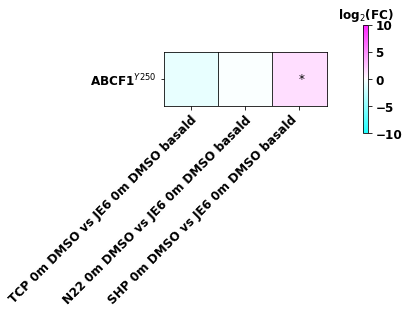

In [27]:
basal[0].heatmap(d_type = "foldchange",
                  path = f"./test", 
                  maxs = [-10,10],
                 )

In [28]:
penis

NameError: name 'penis' is not defined

In [29]:
# Makes all 0m comparison plots for - U0126

make_all_pepplots(basal, 
                  comparisons = [f"{c} q-value" for c in comp_labels[:3]],
                subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 0m DMSO",
                  path = "figs/pep_plots/basal")

In [30]:
stimd = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "stimd" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "stimd" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "stimd" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "stimd" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [31]:
make_all_pepplots(stimd, 
                  comparisons = [f"{c} q-value" for c in comp_labels[3:6]],
                subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 5m DMSO",
                  path = "figs/pep_plots/stim")

In [32]:
s50d = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "5m0md" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "5m0md" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "5m0md" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "5m0md" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [33]:
# Makes all 0m to 5m comparions within -U0126 group
make_all_pepplots(s50d,
                  comparisons =[f"{c} q-value" for c in comp_labels[6:10]],
                 subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 0m DMSO",
                 path = "figs/pep_plots/dmso_timecourse")

In [34]:
basalu = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "basalu" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "basalu" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "basalu" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "basalu" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [35]:
# Makes all 0m comparison plots for + U0126
make_all_pepplots(basalu, 
                  comparisons = [f"{c} q-value" for c in comp_labels[10:13]],
                  subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 0m U0126",
                  path = "figs/pep_plots/u0126_0m")

In [36]:
stimu = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "stimu" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "stimu" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "stimu" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "stimu" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [37]:
# Makes all 0m comparison plots for + U0126
make_all_pepplots(stimu, 
                  comparisons = [f"{c} q-value" for c in comp_labels[13:16]],
                  subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 5m U0126",
                  path = "figs/pep_plots/u0126_5m")

In [38]:
basalpm = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "basalpm" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "basalpm" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "basalpm" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "basalpm" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [39]:
# Makes all 0m comparison plots for + U0126
make_all_pepplots(basalpm, 
                  comparisons = [f"{c} q-value" for c in comp_labels[16:20]],
                  subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 0m DMSO",
                  path = "figs/pep_plots/u0126_basal_pm")

In [40]:
stimpm = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "stimpm" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "stimpm" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "stimpm" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "stimpm" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [41]:
# Makes all 0m comparison plots for + U0126
make_all_pepplots(stimpm, 
                  comparisons = [f"{c} q-value" for c in comp_labels[16:20]],
                  subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 5m U0126",
                  path = "figs/pep_plots/u0126_stim_pm")

In [42]:
s50u = [Peptide(list(file.iloc[i][[col for col in list(file.columns) if "O R" in col or "6 R" in col]].astype(float)),
                    [col for col in list(file.columns) if "O R" in col or "6 R" in col],
                    sample_groups,
                    file.iloc[i]['Modified Sequence'],
                    statistics = list(file.iloc[i][[col for col in list(file.columns) if "q-value" in col and "5m0mu" in col]].astype(float)),
                    statistics_headers =[col for col in list(file.columns) if "q-value" in col and "5m0mu" in col],
                    foldchange = list(file.iloc[i][[col for col in list(file.columns) if "Fold change" in col and "5m0mu" in col]].astype(float)),
                    foldchange_headers = [f"{c[0]} vs {c[1]} {c[2]}" for c in comparisons if c[2] == "5m0mu" ],
                    sites = file.iloc[i]['Site'],
                    gene = file.iloc[i]["Gene name"],
                    unique_id = file.iloc[i]["U_ID"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(file))]

In [43]:
# Makes all 0m vs 5m comparison plots for + U0126
make_all_pepplots(s50u, 
                  comparisons = [f"{c} q-value" for c in comp_labels[20:24]],
                  subset = ["all"], exclude = [], 
                 foldchange_group = "JE6 0m U0126",
                  path = "figs/pep_plots/u0126_timecourse")

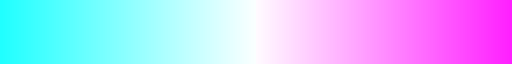

In [44]:
mph.trans